## Imports

In [7]:
import numpy as np
from pprint import pprint
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider
%matplotlib widget

from data_process.data import LabeledData
from data_process.segment import Gps, Vector3
from data_process.signal_tools import signal_filter, signal_transform
from data_process.labels import Label, SeverityLabel

## Load and filter data

In [8]:
data_filepath = '/home/ntkot/theses/ros/bag_db/data_07_10_2023__17_42_10/rosbag2_07_10_2023__17_42_10/'
pickle_file     = data_filepath + 'rosbag2_07_10_2023__17_42_10.pkl'
annotation_file = data_filepath + 'rosbag2_07_10_2023__17_42_10_labels_v2.json'
original_data = LabeledData(pickle_file, annotation_file)

sample_rate = 1 / np.average(original_data['time']['rel'][1:] - original_data['time']['rel'][0:-1])
print(f'Sample rate: {sample_rate:.3f}Hz')

accel_wiener_window = 21
accel_highpass_order = 4
accel_highpass_critical_frequency = 3

gyro_wiener_window = 21
gyro_highpass_order = 3
gyro_highpass_critical_frequency = 2

accel_wiener = lambda x: signal_filter.wiener(x, accel_wiener_window)
gyro_wiener  = lambda x: signal_filter.wiener(x, gyro_wiener_window)

accel_filter = lambda x: signal_filter.butterworth(signal=x, 
                                                   sample_rate=sample_rate, 
                                                   order=accel_highpass_order,
                                                   critical_freq=accel_highpass_critical_frequency,
                                                   btype='highpass')
gyro_filter  = lambda x: signal_filter.butterworth(signal=x, 
                                                   sample_rate=sample_rate, 
                                                   order=gyro_highpass_order, 
                                                   critical_freq=gyro_highpass_critical_frequency,
                                                   btype='highpass')

envelope_fun = lambda x: np.abs(signal_transform.hilbert(x))

wiener_data = original_data.transform(accel_wiener, [['accel', 'x'], ['accel', 'y'], ['accel', 'z']])
wiener_data.transform(gyro_wiener, [['gyro', 'x'],  ['gyro', 'y'],  ['gyro', 'z']], in_place=True)

filtered_data = wiener_data.transform(accel_filter, [['accel', 'x'], ['accel', 'y'], ['accel', 'z']])
filtered_data.transform(gyro_filter, [['gyro', 'x'],  ['gyro', 'y'],  ['gyro', 'z']], in_place=True)

envelope_data = filtered_data.transform(envelope_fun, [['accel', 'x'], ['accel', 'y'], ['accel', 'z'],
                                                       ['gyro',  'x'], ['gyro',  'y'], ['gyro',  'z']])

data_dict = {'original': original_data, 'wiener': wiener_data, 'filtered': filtered_data, 'envelope': envelope_data}

Loading from pickle file...
Sample rate: 99.949Hz


## Severity extraction function

In [12]:
def sensitivity_fun(accel: Vector3, gps: Gps) -> dict[str, float]:
    def rms(a: np.ndarray):
        return np.sqrt(np.mean(a ** 2))
    
    return \
    {
        # 'rms_max_avg': (max(accel.z) + rms(accel.z)) / 2,
        # 'rms': rms(accel.z),
        'max': max(accel.z),
        'scale_by_speed': max(accel.z) / (np.clip(np.average(gps.speed), 15.0, 70.0) / 3.6)
        # 'scale_by_speed': ((max(accel.z) + rms(accel.z)) / 2) / (np.clip(np.average(gps.speed), 15.0, 70.0) / 3.6)
    }

## Plot

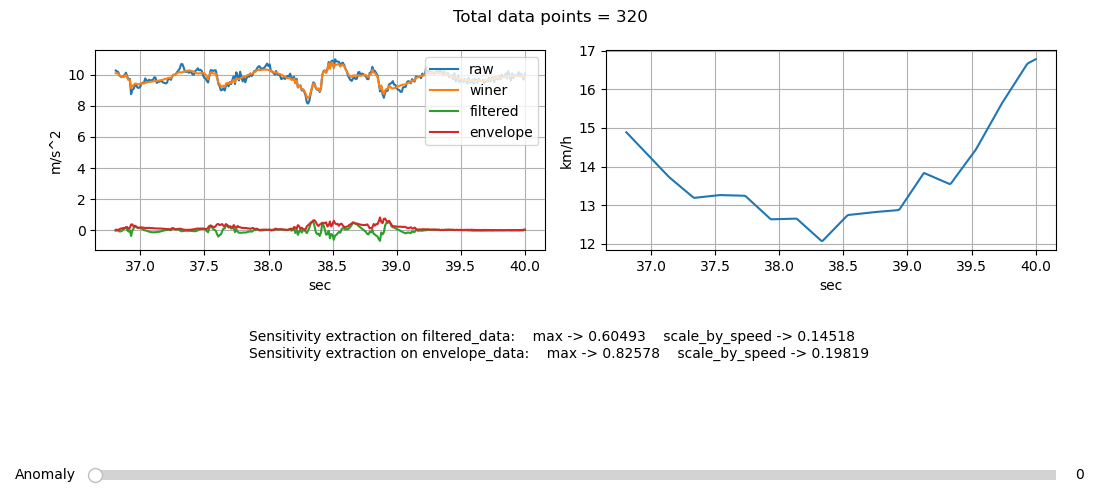

In [13]:
fig = plt.figure(1)
fig.clear()
gs_kw = dict(height_ratios=[1, 0.05, 0.1], width_ratios=[0.45, 0.45])

fig, ax = plt.subplot_mosaic(num=1, mosaic=[['accel_z', 'speed'],
                                            ['text', 'text'],
                                            ['slider', 'slider']], gridspec_kw=gs_kw)


annotation_slices = [(ret[1], ret[2]) for ret in original_data.annotations.to_time_range_indices(original_data['time']['rel'])][:200]
measurement_slider = Slider(ax=ax['slider'], label='Anomaly', 
                            valmin=0, 
                            valmax=len(annotation_slices)-1, 
                            valinit=0, 
                            valstep=1)

def change_plot(idx):
    slice = annotation_slices[idx]
    original_anomaly_data = original_data.data.slice(slice[0], slice[1]+1)
    winer_anomaly_data = wiener_data.data.slice(slice[0], slice[1]+1)
    filtered_anomaly_data = filtered_data.data.slice(slice[0], slice[1]+1)
    envelope_anomaly_data = envelope_data.data.slice(slice[0], slice[1]+1)
    
    filtered_sensitivity = sensitivity_fun(filtered_anomaly_data['accel'], filtered_anomaly_data['gps'])
    envelope_sensitivity = sensitivity_fun(envelope_anomaly_data['accel'], envelope_anomaly_data['gps'])

    ax['accel_z'].clear()
    ax['accel_z'].plot(original_anomaly_data['time']['rel'], original_anomaly_data['accel']['z'], label='raw')
    ax['accel_z'].plot(winer_anomaly_data['time']['rel'], winer_anomaly_data['accel']['z'], label='winer')
    ax['accel_z'].plot(filtered_anomaly_data['time']['rel'], filtered_anomaly_data['accel']['z'], label='filtered')
    ax['accel_z'].plot(envelope_anomaly_data['time']['rel'], envelope_anomaly_data['accel']['z'], label='envelope')
    ax['accel_z'].set_ylabel('m/s^2')
    ax['accel_z'].set_xlabel('sec')
    ax['accel_z'].grid()
    ax['accel_z'].legend(loc='upper right')
    
    ax['speed'].clear()
    ax['speed'].plot(original_anomaly_data['time']['rel'], original_anomaly_data['gps']['speed'])
    ax['speed'].set_ylabel('km/h')
    ax['speed'].set_xlabel('sec')
    ax['speed'].grid()

    ax['accel_z'].sharex(ax['speed'])
    # ax_legend_picking(ax['accel_z'])
    # ax_legend_picking(ax['speed'])

    stats = f"Sensitivity extraction on filtered_data:"
    for key, value in filtered_sensitivity.items():
        stats += f"    {key} -> {value:.5f}"
    stats += "\n"
    stats += f"Sensitivity extraction on envelope_data:"
    for key, value in envelope_sensitivity.items():
        stats += f"    {key} -> {value:.5f}"
    ax['text'].clear()
    ax['text'].text(0.16, 0.5, stats)
    ax['text'].set_frame_on(False)
    ax['text'].get_xaxis().set_visible(False)
    ax['text'].get_yaxis().set_visible(False)

    fig.suptitle(f"Total data points = {len(original_anomaly_data['time']['rel'])}")


change_plot(0)
measurement_slider.on_changed(change_plot)

fig.set_size_inches(11, 5)
fig.tight_layout(h_pad=3.0)

plt.show()

## Per-label analysis of sensitivity metrics

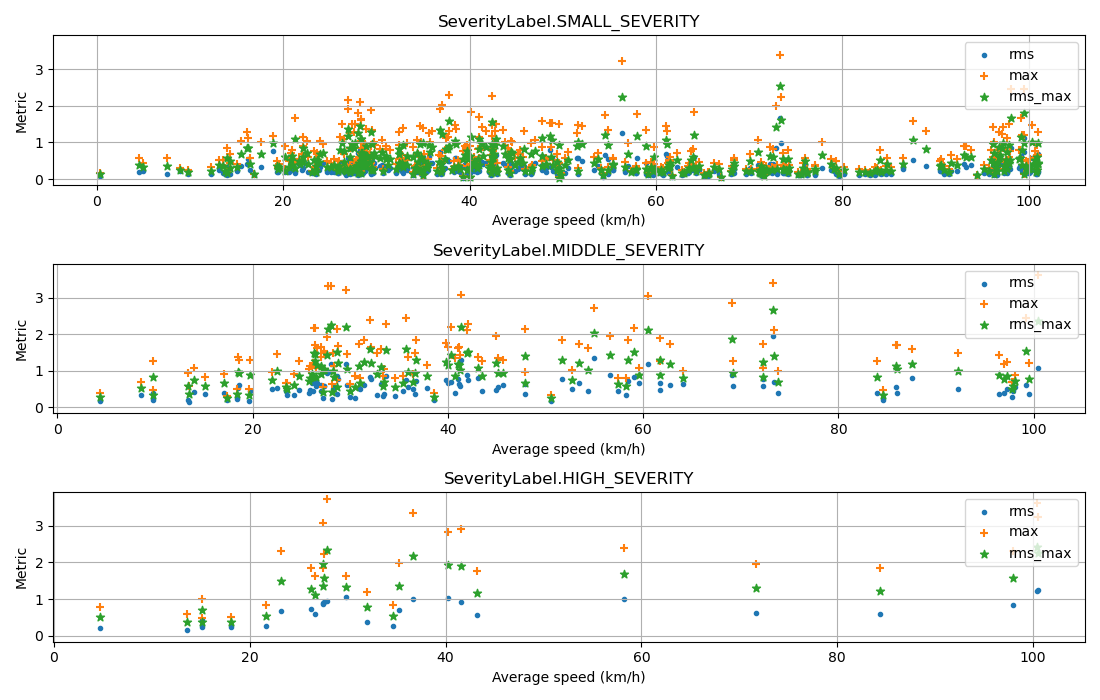

In [11]:
def rms(a: np.ndarray):
        return np.sqrt(np.mean(a ** 2))

def sensitivity_rms(accel: Vector3, gps: Gps) -> dict[str, float]:
    return rms(accel.z)

def sensitivity_max(accel: Vector3, gps: Gps) -> dict[str, float]:
    return max(accel.z)

def sensitivity_rms_max(accel: Vector3, gps: Gps) -> dict[str, float]:
    return ((max(accel.z) + rms(accel.z)) / 2)

filtered_anomalies = [filtered_data.data.slice(ret[1], ret[2]+1) for ret in original_data.annotations.to_time_range_indices(original_data['time']['rel'])]
labels = [ret[0] for ret in original_data.annotations.to_time_range_indices(original_data['time']['rel'])]
speeds = [np.mean(anomaly['gps']['speed']) for anomaly in filtered_anomalies]
metrics = [{'rms': sensitivity_rms(anomaly['accel'], anomaly['gps']),
            'max': sensitivity_max(anomaly['accel'], anomaly['gps']),
            'rms_max': sensitivity_rms_max(anomaly['accel'], anomaly['gps'])}
            for anomaly in filtered_anomalies]

scat_fig = plt.figure(2)
scat_fig.clear()
scat_fig, scat_ax = plt.subplots(num=2, nrows=3, ncols=1, sharey='all')

markers = ['.', '+', '*']
severity_labels = [SeverityLabel.SMALL_SEVERITY, SeverityLabel.MIDDLE_SEVERITY, SeverityLabel.HIGH_SEVERITY]
for ax_i, severity_label in enumerate(severity_labels):
    severity_idx = np.where(np.array([label.severity for label in labels]) == severity_label)[0]
    speeds_value = [speeds[idx] for idx in severity_idx]
    for i, key in enumerate(metrics[0].keys()):
        metric_value = [metrics[idx][key] for idx in severity_idx]
        scat_ax[ax_i].scatter(speeds_value, metric_value, marker=markers[i], label=key)
    scat_ax[ax_i].set_xlabel('Average speed (km/h)')
    scat_ax[ax_i].set_ylabel('Metric')
    scat_ax[ax_i].set_title(severity_label)
    scat_ax[ax_i].legend(loc='upper right')
    scat_ax[ax_i].grid()

scat_fig.set_size_inches(11, 7)
scat_fig.tight_layout()

plt.show()